In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Load the dataset
train_df = pd.read_csv('/kaggle/input/nlp-a3-dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-a3-dataset/test.csv')

# Display the first few rows of the training dataset
print(train_df.head())

# Define a function to clean the text minimally
def clean_text(text):
    # Replace HTML tags with a space
    text = re.sub(r'<.*?>', ' ', text)
    return text

# Apply the cleaning function to the 'text' column directly
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

# Check the cleaned text
print(train_df.head())
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, TensorDataset
import torch
# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize and encode sequences in the training set
max_seq_length = 256  # You can change this as per your dataset analysis

# Tokenize, encode, and pad/truncate sentences in the training and testing sets
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding='max_length', max_length=max_seq_length)
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding='max_length', max_length=max_seq_length)
# Convert encodings to torch tensors
train_seq = torch.tensor(train_encodings['input_ids'])
train_mask = torch.tensor(train_encodings['attention_mask'])
train_y = torch.tensor(train_df['label'].values)

test_seq = torch.tensor(test_encodings['input_ids'])
test_mask = torch.tensor(test_encodings['attention_mask'])
test_y = torch.tensor(test_df['label'].values)

# Define batch size
batch_size = 16

# Create Tensor Datasets
train_data = TensorDataset(train_seq, train_mask, train_y)
test_data = TensorDataset(test_seq, test_mask, test_y)

# Create Data Loaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
from transformers import RobertaForSequenceClassification, RobertaTokenizer


# Load the model
num_labels = len(train_df['label'].unique())  
# print(num_labels)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)


   index                                               text  label
0      0  Zimbabwe annual inflation drops to 209 percent...      0
1      1  More than 1,000 dead in Haiti (09/23/04)-- A m...      0
2      2  Seven die in Japan  #39;suicide pact #39; Japa...      0
3      3  Security No. 1 for Afghan head President Hamid...      0
4      4  Palestinians say they hope Bush accepts dealin...      0
   index                                               text  label
0      0  Zimbabwe annual inflation drops to 209 percent...      0
1      1  More than 1,000 dead in Haiti (09/23/04)-- A m...      0
2      2  Seven die in Japan  #39;suicide pact #39; Japa...      0
3      3  Security No. 1 for Afghan head President Hamid...      0
4      4  Palestinians say they hope Bush accepts dealin...      0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 Train Loss: 0.5482669093242262 Validation Loss: 0.6169981572490472
Epoch 2 Train Loss: 0.2546005661277908 Validation Loss: 0.5930058125119942
Epoch 3 Train Loss: 0.17956040415550228 Validation Loss: 0.5639205345740685
Epoch 4 Train Loss: 0.11230560887473083 Validation Loss: 0.6187534647492262
Accuracy: 0.898
Macro F1 Score: 0.897830405345907
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       125
           1       0.95      0.97      0.96       125
           2       0.86      0.87      0.87       125
           3       0.90      0.88      0.89       125

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500



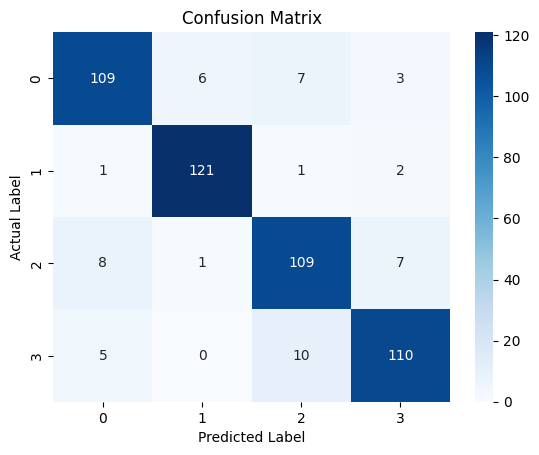

In [4]:
import torch
from transformers import RobertaForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(train_df['label'].unique()))
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

epochs = 4
best_validation_loss = float('inf')

# Splitting train data to create a small validation set
train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = [item.to(device) for item in batch]
        inputs, masks, labels = batch

        model.zero_grad()
        
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in validation_loader:
            batch = [item.to(device) for item in batch]
            inputs, masks, labels = batch

            outputs = model(inputs, attention_mask=masks, labels=labels)
            loss = outputs.loss

            val_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(validation_loader)

    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss} Validation Loss: {avg_val_loss}")

    # Save the best model
    if avg_val_loss < best_validation_loss:
        best_validation_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Testing and Evaluating
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = [item.to(device) for item in batch]
        inputs, masks, labels = batch

        outputs = model(inputs, attention_mask=masks)
        logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
pred_flat = np.argmax(predictions, axis=1).flatten()

# Calculate the accuracy and macro-F1 score
accuracy = accuracy_score(true_labels, pred_flat)
macro_f1 = f1_score(true_labels, pred_flat, average='macro')
print(f"Accuracy: {accuracy}")
print(f"Macro F1 Score: {macro_f1}")

# Classification report
print(classification_report(true_labels, pred_flat))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_flat)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Save the predictions
test_df['preds'] = pred_flat
test_df.to_csv("bert_test.csv", index=False)
